In [44]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

In [45]:
train = shuffle(pd.read_csv("./train.csv", header = None))
test = shuffle(pd.read_csv("./test.csv", header = None))

In [46]:
print("Any missing sample in training set:",train.isnull().values.any())

#I have handled missing value using imputer later in the code
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: True 



In [47]:
print(train.shape)
train_outcome = pd.crosstab(index = train.iloc[:,-1],  # Make a crosstab
                              columns="count")      # Name the count column
train_outcome


(8678, 66)


col_0,count
65,
0,2177
1,2152
2,2202
3,2147


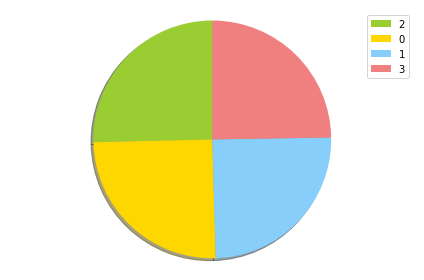

In [48]:
temp = train.iloc[:,-1].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [49]:
Y_train_label = train.iloc[:,-1]
X_train = pd.DataFrame(train.drop(train.columns[[-1,-2]], axis=1))
print("Dimension of Train set",X_train.shape)
Y_test_label = test.iloc[:,-1]
X_test = pd.DataFrame(test.drop(test.columns[[-1,-2]], axis=1))

#handling missing values/Nan in test set
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
imputed_test = my_imputer.fit_transform(X_test)

# Dimension of Train and Test set 
print("Dimension of Test set",X_test.shape,"\n")


Dimension of Train set (8678, 64)
Dimension of Test set (3000, 64) 



In [50]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(Y_train_label)
Y_train = encoder.transform(Y_train_label)

# encoding test labels 
encoder.fit(Y_test_label)
Y_test = encoder.transform(Y_test_label)

#Total Number of Continous and Categorical features in the training set
num_cols = X_train._get_numeric_data().columns
print("Number of numeric features:",num_cols.size)

names_of_predictors = list(X_train.columns.values)


Number of numeric features: 64


In [51]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(imputed_test)

In [41]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
#C = 1, 10, 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [100, 1000]}]
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
# View the accuracy score

print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.9168011062456787 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 



In [43]:
print(confusion_matrix(Y_test_label,Y_pred_label))
print("\n")
print(classification_report(Y_test_label,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))


[[709   1   0   2]
 [  0 776   0   1]
 [  0   9 752  16]
 [  0  13   0 721]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       712
           1       0.97      1.00      0.98       777
           2       1.00      0.97      0.98       777
           3       0.97      0.98      0.98       734

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Training set score for SVM: 0.985826
Testing  set score for SVM: 0.986000
